In [45]:
from __future__ import division

%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('notebook', font_scale=1.3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))
import agent
import blockworld
import model

In [57]:
from utils import get_data
version = '1.4'
data = get_data(version, '../data')
if version in ('1.2', '1.3'):
    df = data['blockworld'].set_index('pid', drop=False)
    pdf = data['participants'].set_index('pid')
    df['completed'] = pdf['completed']
    # HACK due to a bug with 1.2, we have to filter only include subjects that are completed.
    df = df.query('completed')
    df = df.reset_index(drop=True)
else:
    df = data['blockworld']

# HACK due to an error where a participant restarted the task, we drop pid=10
if version == '1.3':
    df = df.loc[df.pid != 10]

if version == '1.4':
    bad_pids = []
    exp_rows = 35
    for pid, rows in df.groupby('pid'):
        if len(rows) == exp_rows:
            continue
        bad_pids.append(pid)
        print(f'Found bad pid {pid} with {len(rows)} problems, but expected {exp_rows}')
    print(f'Removing pids: {bad_pids}. Before {df.shape}')
    df = df.loc[~df.pid.isin(bad_pids)]
    print(f'After {df.shape}')

Found bad pid 5 with 45 problems, but expected 35
Found bad pid 26 with 32 problems, but expected 35
Removing pids: [5, 26]. Before (1722, 10)
After (1645, 10)


In [43]:
%load_ext rpy2.ipython
#%Rpush df
!ls ../data/1.3/blockworld.csv

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
../data/1.3/blockworld.csv


In [10]:
%%R
x = read.csv('../data/1.3/blockworld.csv')
summary(lm(pid ~ pid, data=x))


Call:
lm(formula = pid ~ pid, data = x)

Residuals:
     Min       1Q   Median       3Q      Max 
-23.4371 -11.4371  -0.4371  12.5629  22.5629 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   23.437      0.349   67.16   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 13.53 on 1502 degrees of freedom



In [58]:
mean_bonus = data['participants'].query('completed').bonus.mean()
print(f'mean bonus ${mean_bonus:.02f}')

all_min = []
for pid, pid_df in df.groupby('pid'):
    for _, row in pid_df.iterrows():
        prev_row_elapsed = row.time_elapsed
    minutes = prev_row_elapsed/1000/60
    all_min.append(minutes)
print(f'Mean time {np.mean(all_min):.02f} +- {np.std(all_min):.02f} minutes')

mean bonus $0.77
Mean time 17.85 +- 6.15 minutes


In [49]:
import json
from ast import literal_eval
bwd = pd.read_csv(f'../data/{version}/blockworld.csv')
bwd = bwd.loc[bwd.points.notnull()]
bwd['raw_points'] = bwd['points']/bwd['multiplier']
bwd['states'] = bwd['states'].apply(literal_eval)
bwd['initial_state'] = bwd.states.apply(lambda x: x[0])

for prob, rows in bwd.groupby('initial_state'):
    print(prob, rows.raw_points.quantile([0.05, 0.5, 0.95]).values, 'mean', rows.raw_points.mean())
    

:A,B,D:C [nan nan nan] mean nan
:A,C,E,F:D,B [ 0.9  8.  11. ] mean 7.052631578947368
:B,D,A,C,E:F [2. 3. 7.] mean 4.32
:B,D,C,A:F,E [0.05 3.   5.  ] mean 3.227272727272727
:D,A,C,E:F,B [3.   7.   8.45] mean 6.277777777777778
A,C::B [0. 3. 3.] mean 2.38
D,B:A,C,E,F: [ 0.  8. 10.] mean 7.032258064516129
D,B:A:F,C,E [2.05 5.   5.  ] mean 4.2272727272727275
D,E::F,C,B,A [0. 2. 3.] mean 1.8076923076923077
D:B,A:F,E,C [1.9 4.  5. ] mean 3.75
D:B,C:F,E,A [1.3 3.  4. ] mean 2.8518518518518516
E,A:B,C:F,D [2.2 7.  7. ] mean 5.862068965517241
E,B:A,D:F,C [0. 4. 6.] mean 3.28
E,C:B,A:D [ 4.45  9.   10.  ] mean 8.54
E,D::F,C,A,B [2.2 7.  9. ] mean 6.36
E:B:F,C,D,A [0. 3. 5.] mean 3.4347826086956523
E:C,A,D:F,B [0.1 3.5 6. ] mean 3.5454545454545454
E:C:F,B,A,D [1.   4.   4.75] mean 3.269230769230769
E:D,A,B,C:F [0.05 2.   7.95] mean 3.6363636363636362
E:D,B,A,C:F [0.   2.   9.85] mean 4.083333333333333
F,B,A,D:C:E [0.05 4.   4.95] mean 3.227272727272727
F,B:C,A,D:E [1.3 4.  5. ] mean 3.592592592592

In [59]:
def parse_state(state):
    return tuple((tuple(filter(None, col.split(','))) 
                  for col in state.split(':')))

df.states = df.states.apply(lambda states: list(map(parse_state, states)))

/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [60]:
df['num_actions'] = df['states'].apply(lambda s: len(s) - 1)
df['initial_state'] = df['states'].apply(lambda s: s[0])
df['num_blocks'] = df['initial_state'].apply(lambda initial: blockworld.Blockworld.count_blocks(initial))

df_to_analyze = df.query('num_blocks == 6')

print('# unique states', len(df_to_analyze.initial_state.unique()))
print('# unique pid', len(df_to_analyze.pid.unique()))
print('# rows', df_to_analyze.shape[0], 'exp # rows', len(df_to_analyze.initial_state.unique()) * len(df_to_analyze.pid.unique()))

num_trials = 32
# HACK assuming that pids are in contiguous blocks
df_to_analyze['trial_idx'] = np.tile(
    np.arange(num_trials),
    len(df_to_analyze.pid.unique()))

df_to_analyze['trial_repeat'] = df_to_analyze['trial_idx'] >= num_trials/2

df_to_analyze['true_orig'] = df_to_analyze.apply(
    lambda row: str(row.initial_state[::-1] if row.trial_repeat else row.initial_state), axis=1)

# Identify duplicate states & remove them.
from collections import Counter
duplicate_ct = Counter(df_to_analyze.head(num_trials).initial_state)
duplicate_states = {s for s, ct in duplicate_ct.items() if ct > 1}
print('# duplicate states', len(duplicate_states))
print('before removing duplicates', df_to_analyze.shape)
df_to_analyze = df_to_analyze.loc[~df_to_analyze.initial_state.isin(duplicate_states)]
print('after removing duplicates', df_to_analyze.shape)

print('trial_repeat.value_counts()', df_to_analyze['trial_repeat'].value_counts())
df_to_analyze.iloc[14:18, :]

/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

# unique states 32
# unique pid 47
# rows 1504 exp # rows 1504


/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# duplicate states 0
before removing duplicates (1504, 16)
after removing duplicates (1504, 16)
trial_repeat.value_counts() True     752
False    752
Name: trial_repeat, dtype: int64


/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,high_stakes,initial_points,multiplier,no_bonus,points,states,time_elapsed,times,trial_type,pid,num_actions,initial_state,num_blocks,trial_idx,trial_repeat,true_orig
17,False,0.0,0.0,True,0.0,"[((E,), (C, A, D), (F, B)), ((E, D), (C, A), (...",493148,"[1815, 2555, 3472, 4356, 5468, 6552, 7351, 828...",blockworld,17,16,"((E,), (C, A, D), (F, B))",6,14,False,"(('E',), ('C', 'A', 'D'), ('F', 'B'))"
18,False,0.0,0.0,True,0.0,"[((E, B), (A, D), (F, C)), ((E, B, D), (A,), (...",510351,"[1937, 2749, 4270, 5221, 6122, 6895, 7686, 870...",blockworld,17,14,"((E, B), (A, D), (F, C))",6,15,False,"(('E', 'B'), ('A', 'D'), ('F', 'C'))"
19,False,0.0,0.0,True,0.0,"[((D, E), (), (F, C, B, A)), ((D, E, A), (), (...",529218,"[3196, 4035, 5228, 6354, 7223, 7980, 8825, 983...",blockworld,17,14,"((D, E), (), (F, C, B, A))",6,16,True,"(('F', 'C', 'B', 'A'), (), ('D', 'E'))"
20,False,20.0,1.0,False,4.0,"[((F, B, A, D), (C,), (E,)), ((F, B, A, D), ()...",550656,"[3768, 4612, 5643, 6661, 7455, 9575, 10187, 10...",blockworld,17,16,"((F, B, A, D), (C,), (E,))",6,17,True,"(('E',), ('C',), ('F', 'B', 'A', 'D'))"


In [61]:
print('all probs', len(df_to_analyze.loc[df_to_analyze.pid==20]))
print('unique probs', len(df_to_analyze.loc[df_to_analyze.pid==20].initial_state.unique()))

all probs 32
unique probs 32


/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


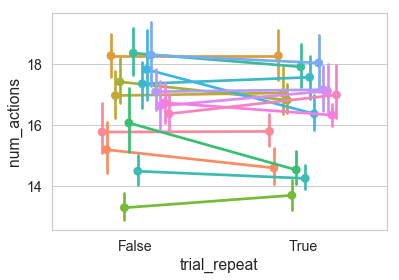

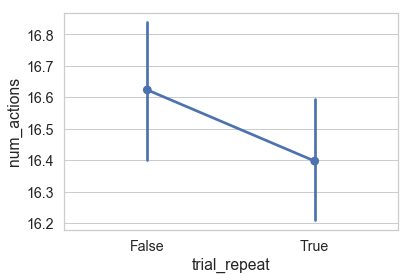

In [62]:
# Show that repeated exposure doesn't change # moves

f, ax = plt.subplots()
sns.pointplot(x="trial_repeat", y="num_actions", hue="true_orig", data=df_to_analyze, dodge=True, ax=ax)
ax.legend().remove()

f, ax = plt.subplots()
sns.pointplot(x="trial_repeat", y="num_actions", data=df_to_analyze, dodge=True, ax=ax)
ax.legend().remove()

In [65]:
df_to_analyze.shape[0] / len(df_to_analyze.pid.unique())

32.0

/Users/carlos/pu/multigoals/env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


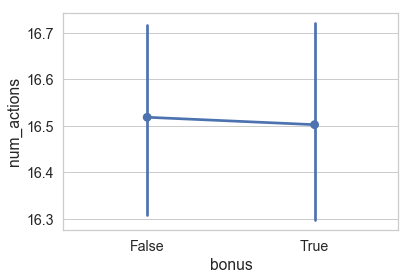

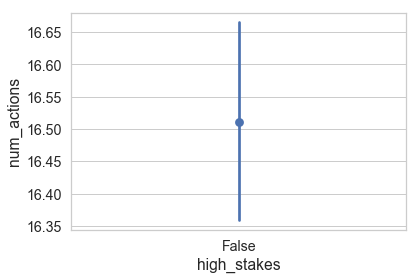

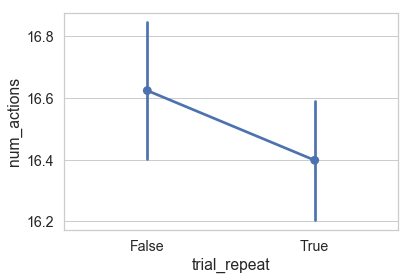

In [66]:
df1 = get_data('1.1', '../data')['blockworld']
df1.states = df1.states.apply(lambda states: list(map(parse_state, states)))
df1['num_actions'] = df1['states'].apply(lambda s: len(s) - 1)
df1['num_blocks'] = df1['states'].apply(lambda s: blockworld.Blockworld.count_blocks(s[0]))
for k in ['high_stakes', 'trial_repeat', 'no_bonus', 'bonus']:
    df1[k] = ['1.1'] * df1.shape[0]
df1 = df1.query('num_blocks==6')

df_to_analyze['bonus'] = ~df_to_analyze['no_bonus']

#df2 = get_data('1.2', '../data')['blockworld']
#df2.states = df2.states.apply(lambda states: list(map(parse_state, states)))
#df2['num_actions'] = df2['states'].apply(lambda s: len(s) - 1)
#df2['high_stakes'] = ['1.2'] * df2.shape[0]

hiidf = df_to_analyze
#hiidf = pd.concat([df1, df_to_analyze])

hiidf.to_csv('comparing-num-actions.csv', index=False)

sns.set_style("whitegrid")
#f, ax = plt.subplots(figsize=(14, 10))
#sns.pointplot(x="trial_repeat", y="num_actions", hue="pid", data=hiidf, dodge=0.1, ax=ax)
#ax.legend().remove()

f, ax = plt.subplots()
sns.pointplot(x="bonus", y="num_actions", data=hiidf, dodge=True, ax=ax)
ax.legend().remove()

f, ax = plt.subplots()
sns.pointplot(x="high_stakes", y="num_actions", data=hiidf, dodge=True, ax=ax)
ax.legend().remove()

f, ax = plt.subplots()
sns.pointplot(x="trial_repeat", y="num_actions", data=hiidf, dodge=True, ax=ax)
ax.legend().remove()

